# Estimating parameters for multiple stocks

## 1. Consider $n$ stocks with models:

$$ S_t^{(k)} = S_0^{(k)} \cdot exp(\mu^{(k)} t + \sigma^{(k)} B_t^{(k)}) $$

__Assuming $cov(B_{t}^i,B_{s}^j) = min\{t,s\} \cdot \rho_{i,j}$ __

__And: __
$$\sigma_k B_t^{(k)} = \sum_{i}^{k} \sigma_{k,i} W_t^{(i)}$$
$$\sigma^2_k = \sum_{j}^{min\{k,j\}} \sigma^2_{k,j}$$

__Or in matrix form: __
$$\begin{bmatrix}
\sigma_1 B^{(1)}\\
\sigma_2 B^{(2)}\\
\sigma_3 B^{(3)}\\
...\\
\sigma_n B^{(n)}
\end{bmatrix}
{=}
\begin{bmatrix}
\sigma_{11}  & 0 & 0 &...&0\\
\sigma_{21}  & \sigma_{22} & 0 &...&0\\
\sigma_{31} & \sigma_{32 }&\sigma_{33} &... &0\\
...&...&...&...&...\\
\sigma_{n1} &\sigma_{n2} &\sigma_{n3} &...&\sigma_{nn}
\end{bmatrix}
\begin{bmatrix}
W^{(1)}\\
W^{(2)}\\
W^{(3)}\\
...\\
W^{(n)}
\end{bmatrix}
$$

__Denote $\{\sigma_{i,j}\}$ as matrix A, and $\odot$ as Hadamard Multiplication operator: __
$$\sigma \odot B = AW$$


__Since cov(W) is just $\Delta t I$: __
$$ cov(AW) = A (\Delta tI) A^T = \Delta t \cdot AA^T $$

__From historical data, $cov(\sigma \odot B)$ is directly observable, a.k.a the covariance matrix of stocks log returns.__
__Scale the covariance matrix by $t$, and decompose it into two matrix: A, A^T.__
__Cholesky decomposition is unique, so: __
$$A = Cholesky(\Sigma/\Delta t)$$

Since A is a low triangular, LU decomposition works too.

\begin{eqnarray}
a\\
\end{eqnarray}

In [2]:
import numpy as np #Handle math objects like vectors and matrixs
import scipy as sp
from scipy.stats import norm # Normal cdf is used
import pandas as pd #Contains data from yahoo
import matplotlib.pyplot as plt # Seeing is believing! --Thrall
from datetime import datetime # Very usefull when you need to operate on date
from datetime import timedelta # Very usefull when you need to operate on date
from yahoo_finance import Share # API from Yahoo to fetch data
%matplotlib inline
float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
pd.options.display.float_format = '{:20,.3f}'.format

* Choose the stocks

In [3]:
universe = ['SPY','GOOG','AAPL','AMZN','MSFT','IBM','M','MNST','PNC','ROST','COO']

In [15]:
n = len(universe)

In [4]:
i = datetime.now()
j = i - timedelta(days=252*2)
currentDate = "%s-%s-%s"%(i.year,i.month,i.day)
startDate = "%s-%s-%s"%(j.year,j.month,j.day)

* M is the dataframe that stores log returns of all the stocks.

In [5]:
count = 0
for symbol in universe:
    equity = Share(symbol)
    df = pd.DataFrame(equity.get_historical(startDate,currentDate))
    df.index = df.Date
    df.drop('Date',1,inplace = True)
    df.sort_index(inplace = True) # ,ascending = False
    df['Adj_Close'] = pd.to_numeric(df['Adj_Close'])
    label = symbol#+'_logReturn'
    df[label] = np.log(1+df.Adj_Close.diff(1)/df.Adj_Close)
#     df.fillna(0,inplace = True)
    df.dropna(inplace = True)
    
    if count==0:
        M = df[[label]].copy()
    else:
        M = M.join(df[[label]])
    
    count += 1


* Solve the covariance matrix of the stocks ($cov(\sigma B) = \Sigma$)

In [6]:
dt = 1/252
covMat = np.cov(M.values.T)
print(covMat/dt)

[[0.016 0.015 0.016 0.017 0.018 0.015 0.014 0.012 0.020 0.012 0.011]
 [0.015 0.036 0.020 0.032 0.028 0.013 0.008 0.018 0.015 0.014 0.013]
 [0.016 0.020 0.050 0.022 0.023 0.014 0.007 0.012 0.017 0.012 0.015]
 [0.017 0.032 0.022 0.074 0.028 0.013 -0.002 0.031 0.015 0.010 0.014]
 [0.018 0.028 0.023 0.028 0.044 0.018 0.011 0.019 0.020 0.014 0.014]
 [0.015 0.013 0.014 0.013 0.018 0.034 0.015 0.008 0.019 0.009 0.006]
 [0.014 0.008 0.007 -0.002 0.011 0.015 0.152 0.011 0.023 0.029 0.012]
 [0.012 0.018 0.012 0.031 0.019 0.008 0.011 0.072 0.006 0.015 0.010]
 [0.020 0.015 0.017 0.015 0.020 0.019 0.023 0.006 0.049 0.013 0.008]
 [0.012 0.014 0.012 0.010 0.014 0.009 0.029 0.015 0.013 0.046 0.010]
 [0.011 0.013 0.015 0.014 0.014 0.006 0.012 0.010 0.008 0.010 0.048]]


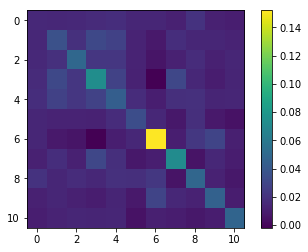

In [7]:
plt.imshow(covMat/dt)
plt.colorbar() 

In [19]:
dt = 1/252
corrMat = np.corrcoef(M.values.T)
print(corrMat)

[[1.000 0.627 0.576 0.496 0.705 0.631 0.297 0.369 0.738 0.455 0.393]
 [0.627 1.000 0.459 0.611 0.692 0.376 0.112 0.359 0.343 0.348 0.321]
 [0.576 0.459 1.000 0.369 0.484 0.327 0.081 0.201 0.353 0.256 0.304]
 [0.496 0.611 0.369 1.000 0.496 0.258 -0.019 0.420 0.257 0.179 0.231]
 [0.705 0.692 0.484 0.496 1.000 0.451 0.133 0.330 0.422 0.316 0.313]
 [0.631 0.376 0.327 0.258 0.451 1.000 0.213 0.162 0.462 0.220 0.139]
 [0.297 0.112 0.081 -0.019 0.133 0.213 1.000 0.104 0.269 0.351 0.138]
 [0.369 0.359 0.201 0.420 0.330 0.162 0.104 1.000 0.106 0.261 0.179]
 [0.738 0.343 0.353 0.257 0.422 0.462 0.269 0.106 1.000 0.270 0.163]
 [0.455 0.348 0.256 0.179 0.316 0.220 0.351 0.261 0.270 1.000 0.215]
 [0.393 0.321 0.304 0.231 0.313 0.139 0.138 0.179 0.163 0.215 1.000]]


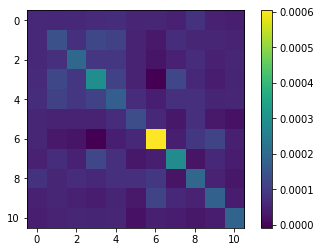

In [20]:
plt.imshow(covMat)
plt.colorbar()

* Perform Cholesky on $\Sigma$ to get A

__$A = Cholesky(\Sigma)$__

In [8]:
A = np.linalg.cholesky(covMat/dt)
print(A)

[[0.125 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.120 0.149 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.128 0.028 0.180 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.135 0.105 0.012 0.211 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.148 0.067 0.010 0.006 0.132 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.117 -0.005 -0.008 -0.010 0.005 0.143 0.000 0.000 0.000 0.000 0.000]
 [0.116 -0.037 -0.038 -0.063 -0.023 0.006 0.363 0.000 0.000 0.000 0.000]
 [0.099 0.044 -0.010 0.061 0.006 -0.020 0.013 0.237 0.000 0.000 0.000]
 [0.164 -0.034 -0.014 -0.013 -0.016 -0.003 0.004 -0.033 0.139 0.000 0.000]
 [0.098 0.017 -0.004 -0.021 -0.009 -0.020 0.047 0.021 -0.018 0.180 0.000]
 [0.086 0.021 0.018 -0.001 0.000 -0.029 0.009 0.003 -0.037 -0.002 0.193]]


* Recover standard deviation of log returns of stocks $\sigma_k$ from formula:

$$\sigma^2_k = \sum_{j}^{min\{k,j\}} \sigma^2_{k,j}$$

In [10]:
np.sum(A**2,axis = 1)*(0.5)

array([0.008, 0.018, 0.025, 0.037, 0.022, 0.017, 0.076, 0.036, 0.025,
       0.023, 0.024])

In [ ]:
d = np.linalg.det(A)**(1/n)
print('The diversity is ', d)